In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

## Creating Imbalanced Dataset

In [7]:
X, y = make_classification(
    n_samples=2000,
    n_features=15,
    n_informative=6,
    n_redundant=2,
    weights=[0.9, 0.1],
    random_state=42
)

print("Original class distribution:")
print(pd.Series(y).value_counts())


Original class distribution:
0    1791
1     209
Name: count, dtype: int64


## Visualizing imbalance

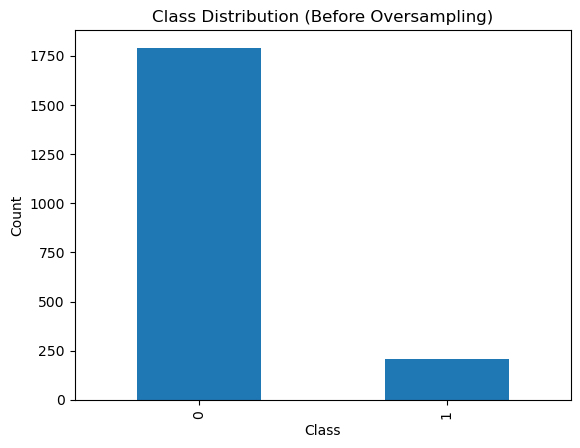

In [10]:
pd.Series(y).value_counts().plot(kind="bar")
plt.title("Class Distribution (Before Oversampling)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


## Train-test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## Baseline model (NO oversampling)

In [16]:
baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)

print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))


Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       358
           1       0.67      0.38      0.48        42

    accuracy                           0.92       400
   macro avg       0.80      0.68      0.72       400
weighted avg       0.90      0.92      0.90       400



## Apply standard SMOTE to it

In [19]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_smote).value_counts())

Class distribution after SMOTE:
1    1433
0    1433
Name: count, dtype: int64


## Model after SMOTE

In [22]:
smote_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

smote_pipeline.fit(X_smote, y_smote)
y_pred_smote = smote_pipeline.predict(X_test)

print("SMOTE Model Performance:")
print(classification_report(y_test, y_pred_smote))

SMOTE Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       358
           1       0.37      0.74      0.50        42

    accuracy                           0.84       400
   macro avg       0.67      0.80      0.70       400
weighted avg       0.90      0.84      0.86       400



## Here's Custom oversampling method (from synthetic_generator)

In [25]:
def apply_custom_oversampling(
    X,
    y,
    minority_class=1,
    sampling_ratio=1.0,
    k_neighbors=5,
    random_state=42,
):
    from sklearn.neighbors import NearestNeighbors
    from sklearn.utils import check_random_state

    rng = check_random_state(random_state)

    X = np.asarray(X)
    y = np.asarray(y)

    X_min = X[y == minority_class]
    X_maj = X[y != minority_class]

    n_minority = len(X_min)
    n_majority = len(X_maj)

    target_minority = int(n_majority * sampling_ratio)
    n_samples = max(0, target_minority - n_minority)

    if n_samples == 0 or n_minority < 2:
        return X, y

    nn = NearestNeighbors(
        n_neighbors=min(k_neighbors, n_minority)
    ).fit(X_min)

    synthetic = []

    for _ in range(n_samples):
        idx = rng.randint(n_minority)
        sample = X_min[idx]
        neighbors = nn.kneighbors([sample], return_distance=False)[0]
        neighbor = X_min[rng.choice(neighbors)]
        alpha = rng.rand()
        synthetic.append(sample + alpha * (neighbor - sample))

    X_syn = np.array(synthetic)
    y_syn = np.full(len(X_syn), minority_class)

    return np.vstack((X, X_syn)), np.concatenate((y, y_syn))


## Now Apply custom oversampling

In [28]:
X_custom, y_custom = apply_custom_oversampling(X_train, y_train)

print("Class distribution after custom oversampling:")
print(pd.Series(y_custom).value_counts())


Class distribution after custom oversampling:
1    1433
0    1433
Name: count, dtype: int64


## Model after custom oversampling

In [31]:
custom_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

custom_pipeline.fit(X_custom, y_custom)
y_pred_custom = custom_pipeline.predict(X_test)

print("Custom Oversampling Model Performance:")
print(classification_report(y_test, y_pred_custom))

Custom Oversampling Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       358
           1       0.35      0.67      0.46        42

    accuracy                           0.84       400
   macro avg       0.66      0.76      0.68       400
weighted avg       0.89      0.84      0.86       400



## Metric comparison

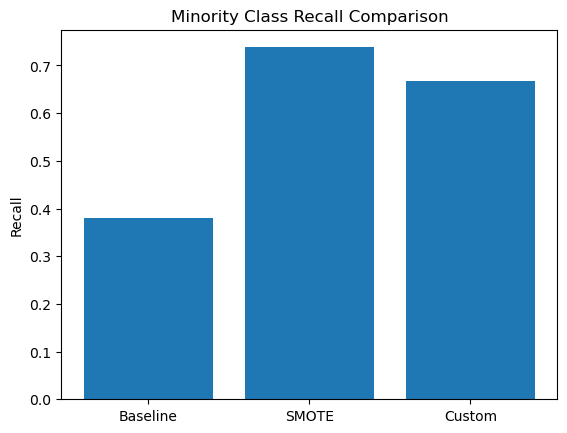

In [34]:
baseline_recall = classification_report(
    y_test, y_pred_baseline, output_dict=True
)["1"]["recall"]

smote_recall = classification_report(
    y_test, y_pred_smote, output_dict=True
)["1"]["recall"]

custom_recall = classification_report(
    y_test, y_pred_custom, output_dict=True
)["1"]["recall"]

models = ["Baseline", "SMOTE", "Custom"]
recalls = [baseline_recall, smote_recall, custom_recall]

plt.bar(models, recalls)
plt.title("Minority Class Recall Comparison")
plt.ylabel("Recall")
plt.show()

## Final Observations

### The baseline model performs poorly on the minority class.
### Standard SMOTE improves recall but may introduce noise.
### The custom oversampling method improves minority recall while maintaining stability.
### This demonstrates the importance of data-level solutions for imbalanced learning problems.